In [1700]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import ttest_1samp

In [1701]:
df = pd.read_csv("../replication-materials-yuanninghuang-1/CECC/CES22_Common.csv")

/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_66670/2776905057.py:1: DtypeWarning: Columns (359,360,363,364,613,614,617,618) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../replication-materials-yuanninghuang-1/CECC/CES22_Common.csv")


In [1728]:
df

,caseid,tookpost,commonweight,commonpostweight,CCEStake,add_confirm,inputzip,birthyr,gender4,gender4_t,educ,race,race_other,hispanic,multrace_1,multrace_2,multrace_3,multrace_4,multrace_5,multrace_8,multrace_97,multrace_98,comptype,votereg,votereg_f,regzip,pid3,pid3_t,pid7,inputstate,region,ccesmodule,CC22_300_1,CC22_300_2,CC22_300_3,CC22_300_4,CC22_300_5,CC22_300a,CC22_300c,CC22_300b_1,CC22_300b_2,CC22_300b_3,CC22_300b_4,CC22_300b_5,CC22_300b_6,CC22_300b_7,CC22_300b_8,CC22_300d_1,CC22_300d_2,CC22_300d_3,CC22_300d_4,CC22_300d_5,CC22_300d_6,CC22_302,CC22_303,CC22_304,CC22_305_1,CC22_305_2,CC22_305_3,CC22_305_4,CC22_305_5,CC22_305_6,CC22_305_7,CC22_305_9,CC22_305_10,CC22_305_11,CC22_305_12,CC22_305_13,CC22_307,CC22_309a_1,CC22_309a_2,CC22_309a_3,CC22_309a_4,CC22_309a_5,CC22_306,CC22_309b_1,CC22_309b_2,CC22_309b_3,CC22_309b_4,CC22_309c_1,CC22_309c_2,CC22_309c_3,CC22_309c_4,CC22_309c_5,CC22_309c_6,CC22_309c_7,CC22_309c_8,CC22_309c_9,CC22_309c_10,CC22_309dx_1,CC22_309dx_2,CC22_309dx_3,CC22_309dx_4,CC22_309dx_5,CC22_309dx_6,CC22_309dx_7,CC22_309dx_8,CC22_309dx_9,CC22_309d_t,CC22_309e,CC22_309f,CC22_310a,CC22_310b,CC22_310c,CC22_310d,CC22_311a,CC22_311b,CC22_311c,CC22_311d,CC22_320a,CC22_320b,CC22_320c,CC22_320d,CC22_320e,CC22_320f,CC22_320g,CC22_320h,cit1,immstat,CC22_321_1,CC22_321_2,CC22_321_3,CC22_321_4,CC22_321_5,CC22_321_6,CC22_321_7,CC22_321_8,CC22_327a,CC22_327b,CC22_327c,CC22_327d,CC22_330a,CC22_330b,CC22_330c,CC22_330d,CC22_330e,CC22_330f,CC22_331a,CC22_331b,CC22_331c,CC22_331d,CC22_332a,CC22_332b,CC22_332c,CC22_332d,CC22_332e,CC22_332f,CC22_333,CC22_333a,CC22_333b,CC22_333c,CC22_333d,CC22_333e,CC22_334a,CC22_334b,CC22_334c,CC22_334d,CC22_334e,CC22_334f,CC22_334g,CC22_334h,CC22_340a,CC22_340b,CC22_340c,CC22_340d,CC22_340e,CC22_340f,CC22_340g,CC22_340h,CC22_340i,CC22_340j,CC22_340k,CC22_340l,CC22_340m,CC22_340n,CC22_350a,CC22_350b,CC22_350c,CC22_350d,CC22_350e,CC22_350f,CC22_350g,CC22_350h,CC22_355a,CC22_355b,CC22_355c,CC22_355d,CC22_355e,CC22_360,CC22_361,urbancity,urbancity_t,presvote20post,presvote20post_t,CC22_363,CC22_365_voted,CC22_365_voted_t,CC22_365b_voted,CC22_365b_voted_t,CC22_366_voted,CC22_366_voted_t,CC22_367_voted,CC22_367_voted_t,CC22_365,CC22_365_t,CC22_365a,CC22_365a_t,CC22_365b,CC22_365b_t,CC22_365c,CC22_365c_t,CC22_366,CC22_366_t,CC22_367,CC22_367_t,CC22_367a,CC22_367a_t,ideo5,employ,employ_t,hadjob,investor,pew_bornagain,pew_religimp,pew_churatd,pew_prayer,religpew,religpew_t,religpew_protestant,religpew_protestant_t,religpew_baptist,religpew_baptist_t,religpew_methodist,religpew_methodist_t,religpew_nondenom,religpew_nondenom_t,religpew_lutheran,religpew_lutheran_t,religpew_presby,religpew_presby_t,religpew_pentecost,religpew_pentecost_t,religpew_episcop,religpew_episcop_t,religpew_christian,religpew_christian_t,religpew_congreg,religpew_congreg_t,religpew_holiness,religpew_holiness_t,religpew_reformed,religpew_reformed_t,religpew_advent,religpew_advent_t,religpew_catholic,religpew_catholic_t,religpew_mormon,religpew_mormon_t,religpew_orthodox,religpew_orthodox_t,religpew_jewish,religpew_jewish_t,religpew_muslim,religpew_muslim_t,religpew_buddhist,religpew_buddhist_t,religpew_hindu,religpew_hindu_t,marstat,union,union_coverage,unionhh,dualcit,dualctry,ownhome,ownhome_t,newsint,faminc_new,milstat_1,milstat_2,milstat_3,milstat_4,milstat_5,child18,child18num,healthins_1,healthins_2,healthins_3,healthins_4,healthins_5,healthins_6,healthins2,phone,internethome,internetwork,CC22_hisp_1,CC22_hisp_2,CC22_hisp_3,CC22_hisp_4,CC22_hisp_5,CC22_hisp_6,CC22_hisp_7,CC22_hisp_8,CC22_hisp_9,CC22_hisp_10,CC22_hisp_11,CC22_hisp_12,CC22_hisp_t,CC22_asian_1,CC22_asian_2,CC22_asian_3,CC22_asian_4,CC22_asian_5,CC22_asian_6,CC22_asian_7,CC22_asian_8,CC22_asian_9,CC22_asian_10,CC22_asian_11,CC22_asian_12,CC22_asian_13,CC22_asian_14,CC22_asian_15,CC22_asian_t,presvote16post,presvote16post_t,industry,sexuality,transgender,cdid117,cdid118,lookupzip,LegName,LowerChamberName,UpperChamberName,CurrentGovName,CurrentGovParty,CurrentHou

In [1703]:
# Create a new dataframe with 'caseid', 'voted', and 'senate_vote_choice' columns
new_df = df[['caseid']].copy()

# Create the 'voted' variable
new_df['if_voted_2022'] = (df['CC22_401'] == 5).astype(int)

def get_senate_vote_choice(row):
    vote_20 = row['presvote20post']
    pre_vote = row['CC22_365_voted']
    post_vote = row['CC22_411']
    pre_state = row['inputstate']
    post_state = row['inputstate_post']

    def get_candidate_info(vote, suffix=''):
        if 1 <= vote <= 4:
            return row[f'SenCand{int(vote)}Name{suffix}'], row[f'SenCand{int(vote)}Party{suffix}']
        else:
            return None, None

    #if individual voted for trump in 2020, code -1, if voted for Biden code 1, others and missing and did not vote code 0
    if vote_20 == 2:
        vote_20 = -1
    elif vote_20 == 1:
        vote_20 = 1
    else:
        vote_20 = 0


    if pd.notna(pre_vote) and pd.notna(post_vote):
        if pre_vote == post_vote:
            name, party = get_candidate_info(post_vote, '_post')
            return vote_20, post_vote, name, party, post_state
        else:
            return vote_20, float('nan'), None, None, None  # set as missing if contradictory responses
    elif pd.notna(pre_vote):
        name, party = get_candidate_info(pre_vote)
        return vote_20, pre_vote, name, party, pre_state
    elif pd.notna(post_vote):
        name, party = get_candidate_info(post_vote, '_post')
        return vote_20, post_vote, name, party, post_state
    else:
        if pd.isna(pre_state):
            return vote_20, float('nan'), None, None, post_state
        elif pd.isna(pre_state):
            return vote_20, float('nan'), None, None, pre_state
        elif pre_state == post_state:
            return vote_20, float('nan'), None, None, pre_state  
        else:
            return vote_20, float('nan'), None, None, None 


# Apply the updated function to the dataframe
new_df[['vote_2020', 'senate_vote_choice', 'senator_name', 'party', 'state']] = df.apply(get_senate_vote_choice, axis=1, result_type='expand')

#if voted for republican senator, party_voted is -1, if voted for democrats, party_voted is 1. if other or missing, the value is 0
new_df['vote_2022'] = new_df['party'].apply(lambda party: 1 if party == 'Democratic' else (-1 if party == 'Republican' else 0))
new_df = new_df.drop(columns=['party'])

#turn_out_diff measures how people's voting behavior changes.
# If the variable is negative, people voted more for republican in the midterm compared to 2020
new_df['turn_out_diff'] = new_df['vote_2022'] - new_df['vote_2020']

new_df.head()

,caseid,if_voted_2022,vote_2020,senate_vote_choice,senator_name,state,vote_2022,turn_out_diff
0,1983126005,1,1.0,NaN,NaN,26.0,0,-1.0
1,1983126559,1,1.0,NaN,NaN,25.0,0,-1.0
2,1983126197,1,1.0,1.0,John Fetterman,42.0,1,0.0
3,1979974411,1,1.0,1.0,Richard Blumenthal,9.0,1,0.0
4,1983130427,0,0.0,NaN,NaN,24.0,0,0.0


In [1704]:
# Add the specified columns from 'df' to 'new_df'
control_vr = ['birthyr', 'gender4', 'educ', 'race', 'faminc_new', 'marstat', 'urbancity', 'region', 'presvote16post', \
    'pew_bornagain', 'pew_religimp', 'pew_churatd', 'pew_prayer', 'religpew', 'ideo5', 'CC22_320a', 'CC22_320g', 'CC22_320h', 'CurrentSen1Party', 'CurrentSen2Party',\
    'CC22_430a_8', 'CC22_310b', 'CC22_303', 'CC22_304']
important_vr = ['pid3', 'pid7', 'CC22_332a', 'CC22_332b', 'CC22_332c', 'CC22_332d', 'CC22_332e', 'CC22_332f', 'CC22_350d']
new_df = pd.concat([new_df, df[control_vr]], axis=1)
new_df = pd.concat([new_df, df[important_vr]], axis=1)

In [1705]:
# Cleaning columns
new_df['age'] = 2022 - df['birthyr']
new_df = new_df.drop('birthyr', axis=1)

In [1706]:
#if there is political involvement, give vaue 1, else 0
new_df['pol_involve'] = new_df['CC22_430a_8'].apply(lambda x: 0 if x > 6 else 1)
new_df = new_df.drop(columns=['CC22_430a_8'])

#Calculate approval for senators in different political parties
recode_map = {1: 2, 2: 1, 5: 0, 3: -1, 4: -2}
new_df['CC22_320g'] = new_df['CC22_320g'].map(recode_map)
df['CC22_320h'] = df['CC22_320h'].map(recode_map)

# Define a function to calculate the average rating for a given party
def get_party_attitude(row, party):
    ratings = []
    if row['CurrentSen1Party'] == party:
        ratings.append(row['CC22_320g'])
    if row['CurrentSen2Party'] == party:
        ratings.append(row['CC22_320h'])
    
    return sum(ratings) / len(ratings) if ratings else None

# Create new columns 'attitude_towards_party' as the average rating for each party
new_df['attitude_towards_dem'] = new_df.apply(lambda row: get_party_attitude(row, 'Democratic'), axis=1)
new_df['attitude_towards_rep'] = new_df.apply(lambda row: get_party_attitude(row, 'Republican'), axis=1)

# Drop the original columns
new_df = new_df.drop(columns=['CC22_320g', 'CC22_320h', 'CurrentSen1Party', 'CurrentSen2Party'])

In [1707]:
column_mapping = {'senator_name': 'senator_voted', 'gender4':'gender', 'faminc_new': 'fam_income',\
    'ideo5': 'pol_ideo', 'CC22_320a': 'approval_biden', 'CC22_310b': 'know_senate', 'CC22_303': 'income_change', 'CC22_304': 'price_change',\
    'pid3': 'party_identified', 'pid7': 'party_strength', 'CC22_332a':'abortion_all_cases', 'CC22_332b':'abortion_some_cases', \
    'CC22_332c': 'abortion_before_20weeks', 'CC22_332d': 'abortion_coverage', 'CC22_332e': 'abortion_funds', 'CC22_332f': 'abortion_illegal', 'CC22_350d': 'congress_abortion'}

new_df = new_df.rename(columns=column_mapping)

In [1708]:
#create column for states with abortion on ballot
#source: https://ballotpedia.org/2022_abortion-related_ballot_measures
abortion_states = [6, 21, 26, 30, 50]
new_df['abortion_ballot'] = new_df['state'].apply(lambda row: 1 if row in abortion_states else 0)

In [1709]:
#Change coding for gender. Man is 0, Woman is 1. Change non-binary and others as NaN
new_df['gender'] = new_df['gender'].apply(lambda value: 1 if value == 2 else (0 if value == 1 else None))

In [1710]:
#Code education. Did not graduate from high school as 0, high school grad as 1, some colege (no degree yet) as 2, 2 year college as 3
# 4 year college as 4, postgrad as 5
new_df['educ'] = new_df['educ'].apply(lambda value: value - 1)

In [1711]:
def get_dummy(df, old_col, column_mapping):
    dummies = pd.get_dummies(df[old_col], prefix=old_col)
    dummies = dummies.rename(columns=column_mapping)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(columns=old_col)
    return df

#Race
# Create dummy variables for the new 'race_mapped' column, excluding the 'White' category
# Code Native American, Middle Eastern, two + races, other as missing
new_df['race'] = new_df['race'].apply(lambda value: None if value in [5,6,7, 8] else value)
column_mapping = {'race_1.0': 'race_white', 'race_2.0': 'race_black', 'race_3.0': 'race_hispanic', 'race_4.0': 'race_asian'}
new_df = get_dummy(new_df, 'race', column_mapping)

In [1712]:
#Code family income to start with 0, change prefer not to say to None
new_df['fam_income'] = new_df['fam_income'].apply(lambda value: None if value in [97, -1] else value - 1)

In [1713]:
#Code marstat to start with 0, create dummy variable
new_df['marstat'] = new_df['marstat'].apply(lambda value: None if value == -1 else value - 1)
column_mapping = {'marstat_0.0': 'marstat_married', 'marstat_1.0': 'marstat_separated', 'marstat_2.0': 'marstat_divorced', 'marstat_3.0': 'marstat_widowed',\
    'marstat_4.0': 'marstat_never_married', 'marstat_5.0': 'marstat_domestic'}
new_df = get_dummy(new_df, 'marstat', column_mapping)

In [1714]:
#Code urbancity, if respondent live in city, code 3, suburb = 2, town =1, rural area = 0. other and missing as NaN
new_df['urbancity'] = new_df['urbancity'].apply(lambda value: 0 if value == 4 else (1 if value == 3 else (2 if value == 2 else (3 if value == 1 else None))))

In [1715]:
#Create dummy variable for region
column_mapping = {'region_1': 'region_northeast', 'region_2': 'region_midwest', 'region_3': 'region_south', 'region_4': 'region_west'}
new_df = get_dummy(new_df, 'region', column_mapping)

In [1716]:
#For voting outcome in 2016, Code voted for Clinton as 1, Trump as -1, other candidates as 2, did not vote as 0
new_df['presvote16post'] = new_df['presvote16post'].apply(lambda value: -1 if value == 2 else (2 if value in [3,4,5,6] else (1 if value == 1 else (0 if value == 7 else None))))


In [1717]:
#Code born-again/evangelical Christian as 1, No as 0
new_df['pew_bornagain'] = new_df['pew_bornagain'].apply(lambda value: 0 if value == 2 else (1 if value == 1 else None))

#Code religion importance, not important as 0, very important as 3
new_df['pew_religimp'] = new_df['pew_religimp'].apply(lambda value: 0 if value == 4 else (1 if value == 3 else (2 if value ==2 else (4 if value == 1 else None))))

#Code church attendance, never and don't know as 0, more than once a week as 5
new_df['pew_churatd'] = new_df['pew_churatd'].apply(lambda value: 0 if value in [6,7] else (1 if value == 5 else (2 if value == 4 else (3 if value == 3 else (4 if value == 2 else (5 if value == 1 else None))))))

#Code prayer, never and don't know as 0, several times a day as 6
new_df['pew_prayer'] = new_df['pew_prayer'].apply(lambda value: 0 if value in [7,8] else (1 if value == 6 else (2 if value == 5 else (3 if value == 4 else (4 if value == 3 else (5 if value == 2 else (6 if value == 1 else None)))))))

In [1718]:
#Code present religion, combine atheist, agnostic, nothing in particular together and code them as 0. Code something else and missing as NaN
new_df['religpew'] = new_df['religpew'].apply(lambda value: 0 if value in [9, 10, 11] else (None if value in [12, -1] else value))
column_mapping = {'religpew_0.0': 'religpew_not_religious', 'religpew_1.0': 'religpew_protestant', 'religpew_2.0': 'religpew_catholic', 'religpew_3.0': 'religpew_mormon',\
     'religpew_4.0': 'religpew_orthodox', 'religpew_5.0': 'religpew_jewish','religpew_6.0': 'religpew_muslim','religpew_7.0': 'religpew_buddhist','religpew_8.0': 'religpew_hindu'}
new_df = get_dummy(new_df, 'religpew', column_mapping)

In [1719]:
#Code political viewpoint, very liberal as 2, moderate as 0, very conservative as -2. Not sure and missing as NaN
new_df['pol_ideo'] = new_df['pol_ideo'].apply(lambda value: 0 if value == 3 else (1 if value == 2 else (2 if value == 1 else (-1 if value == 4 else (-2 if value == 5 else None)))))

#Code approval for biden, strongly approve as 2, strongly disapprove as -2, not sure as 0. 
new_df['approval_biden'] = new_df['approval_biden'].apply(lambda value: 0 if value == 5 else (1 if value == 2 else (2 if value == 1 else (-1 if value == 3 else (-2 if value == 4 else None)))))

#Code knwoledge of us senate, if the person correctly answered the question Which party has a majority of seats in the US Senate (democrats), they receive 1
# If they respond incorrectly (republican, neither), they receive -1
# If they are not sure, receive 0. Missing is coded as None
new_df['know_senate'] = new_df['know_senate'].apply(lambda value: 0 if value == 4 else (1 if value == 2 else (-1 if value in [1, 3] else None)))

#Code change in annual income. Code increased a lot as 2, decreased a lot as -2, same as 0
new_df['income_change'] = new_df['income_change'].apply(lambda value: 0 if value == 3 else (1 if value == 2 else (2 if value == 1 else (-1 if value == 4 else (-2 if value == 5 else None)))))

#Code change in prices of everyday goods. Code increased a lot as 2, decreased a lot as -2, same as 0
new_df['price_change'] = new_df['price_change'].apply(lambda value: 0 if value == 3 else (1 if value == 2 else (2 if value == 1 else (-1 if value == 4 else (-2 if value == 5 else None)))))

#Code party registered. Registered democrats as 1, repblican as -1, no party, independent as 0, others as NaN
# new_df['party_registered'] = new_df['party_registered'].apply(lambda value: 0 if value == 1 else (1 if value == 2 else (-1 if value ==3 else None)))

#Code party identified, democrats as 1, repblican as -1, no party, independent and not sure as 0, others as NaN
new_df['party_identified'] = new_df['party_identified'].apply(lambda value: 0 if value in [3,5] else (1 if value == 1 else (-1 if value == 2 else None)))

#Code party strength, strong democrats as 3, not very strong democrats as 2, democratic party as 1. Neither and not sure as 0
new_df['party_strength'] = new_df['party_strength'].apply(lambda value: 0 if value in [4, 8, 9] else (1 if value == 3 else (2 if value == 2 else (3 if value == 1 else (-1 if value == 5 else (-2 if value == 6 else (-3 if value == 7 else None)))))))

#Code support of various statements of abortion
for var in ['abortion_all_cases', 'abortion_some_cases', 'abortion_before_20weeks', 'abortion_coverage', 'abortion_funds', 'abortion_illegal', 'congress_abortion']:
    new_df[var] = new_df[var].apply(lambda value: 0 if value == 2 else (1 if value == 1 else None))

In [1720]:
#Only select states that participated in the senate election in 2022
new_df = new_df[new_df['state'].isin([1, 2, 4, 5, 6, 8, 9, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 29, 32, 33, 36, 37, 38, 39, 40, 41, 42, 45, 46, 49, 50, 53, 55])]

In [1721]:
#drop individuals who did not vote or who vote for both other parties in 2020 and 2022 
new_df = new_df[(new_df["vote_2020"] != 0) & (new_df["vote_2022"] != 0)]

In [1722]:
new_df = new_df.drop(columns=['caseid'])

In [1723]:
#check for missing value
missing_values_count = new_df.isnull().sum()
missing_values = missing_values_count[missing_values_count > 0]
print(missing_values)

gender                       145
fam_income                  2173
urbancity                    142
presvote16post               240
pew_bornagain                 10
pew_religimp                   6
pew_churatd                   11
pew_prayer                     6
pol_ideo                     503
approval_biden                11
know_senate                   10
income_change                 29
price_change                  56
party_identified             946
abortion_all_cases            15
abortion_some_cases           19
abortion_before_20weeks       13
abortion_coverage             10
abortion_funds                14
abortion_illegal              16
congress_abortion              1
attitude_towards_dem        9400
attitude_towards_rep       13371
dtype: int64


In [1724]:
#Handle missing value 
new_df = new_df[new_df['presvote16post'].notna()]
new_df = new_df.drop(columns=['attitude_towards_dem', 'attitude_towards_rep', 'senate_vote_choice', 'senator_voted'])
new_df = new_df[new_df['pol_ideo'].notnull() & new_df['party_identified'].notnull()]

In [1725]:
#For missing values in all columns, fill them with mean
new_df[new_df.columns.to_list()] = new_df[new_df.columns.to_list()].fillna(new_df[new_df.columns.to_list()].mean())

In [1726]:
#check for missing value
missing_values_count = new_df.isnull().sum()
missing_values = missing_values_count[missing_values_count > 0]
print(missing_values)

Series([], dtype: int64)


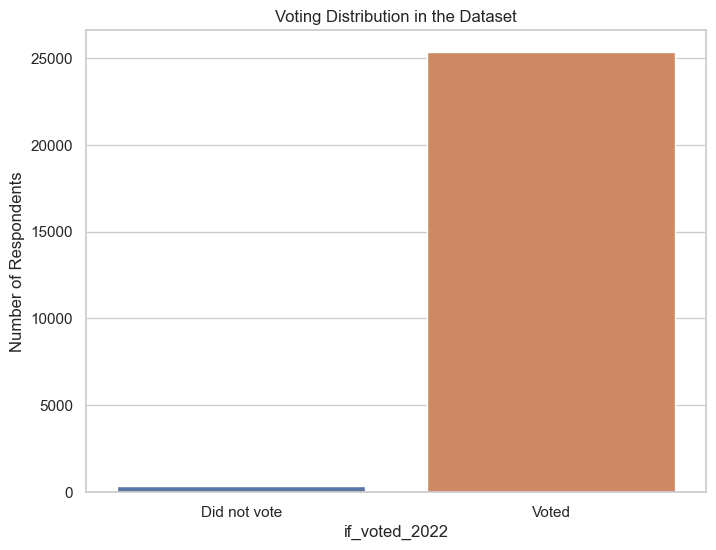

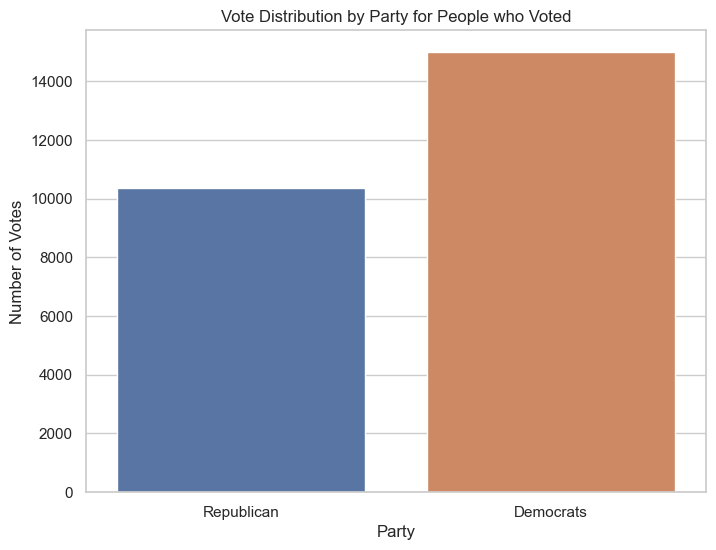

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (5).

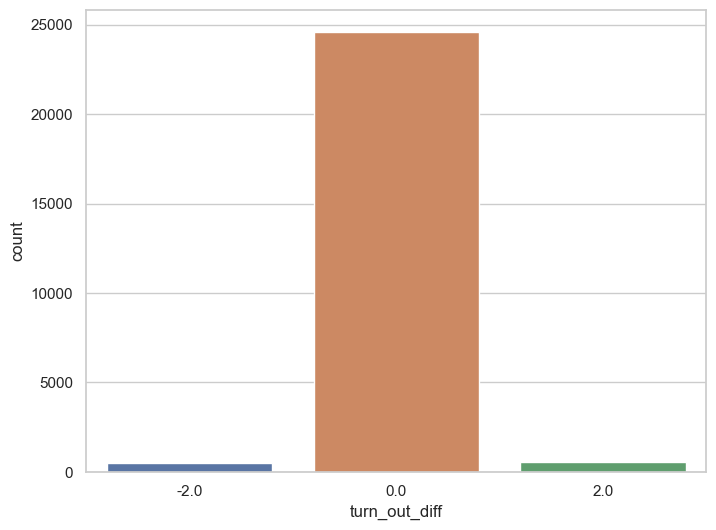

In [1727]:
# Set the style for the plots
sns.set(style='whitegrid')

# Plot the distribution of how many people voted in the dataset
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=new_df, x='if_voted_2022')
ax.set_xticklabels(['Did not vote', 'Voted'])
ax.set_title('Voting Distribution in the Dataset')
ax.set_ylabel('Number of Respondents')
plt.show()

# Plot the distribution of people who voted for each party
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=new_df[new_df['if_voted_2022'] == 1], x='vote_2022')
ax.set_xticklabels(['Republican', 'Democrats'])
ax.set_title('Vote Distribution by Party for People who Voted')
ax.set_xlabel('Party')
ax.set_ylabel('Number of Votes')
plt.show()

# Plot the distribution of turn_out_diff
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=new_df, x='turn_out_diff')
ax.set_xticklabels(['Dem to Rep', 'Rep to No Vote / No Vote to Dem', 'No Change', 'Dem to No Vote / No Vote to Rep', 'Rep to Dem'])
ax.set_title('Turn Out Difference Distribution in the Dataset')
ax.set_ylabel('Number of Respondents')
plt.xticks(rotation=45)
plt.show()

In [ ]:
#create copy of dataframe for exact matching
prop_match_df = new_df.copy()

In [ ]:
X_var = ['abortion_ballot']
Y_var = ['turn_out_diff']
Z_var = [z for z in new_df.columns.to_list() if z not in ['if_voted_2022', 'vote_2020','vote_2022','state', 'turn_out_diff', 'abortion_ballot']]

In [ ]:
def get_matching(prop_match_df, Z_var, X_var, caliper=0.01):
    # Prepare the feature set (Z) and the treatment indicator (W)
    Z = prop_match_df[Z_var]
    X = prop_match_df[X_var]

    # Estimate propensity scores using logistic regression
    lr = LogisticRegression(max_iter=1000)
    lr.fit(Z, X)
    prop_match_df['propensity_score'] = lr.predict_proba(Z)[:, 1]

    # Split treated and control observations
    treated = prop_match_df[prop_match_df['abortion_ballot'] == 1]
    control = prop_match_df[prop_match_df['abortion_ballot'] == 0]

    # Match treated and control observations based on propensity scores
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(control[['propensity_score']])
    distances, indices = nn.kneighbors(treated[['propensity_score']])
    indices = indices.reshape(-1)

    # Create a matched dataset
    matched_control_indices = []
    matched_treated_indices = []
    for i, (dist, idx) in enumerate(zip(distances, indices)):
        if dist <= caliper:
            matched_control_indices.append(idx)
            matched_treated_indices.append(i)

    matched_control = control.iloc[matched_control_indices]
    matched_treated = treated.iloc[matched_treated_indices]

    # Concatenate matched treated and control observations
    matched_data = pd.concat([matched_treated, matched_control], axis=0).reset_index(drop=True)
    rows, _ = matched_data.shape
    print("Number of instances in total matches ", rows)
    return matched_control, matched_treated, matched_data

def validate_matching(Z_var, matched_control, matched_treated, matched_data):
    #change data type of variables to prevent underflow
    for var in Z_var:
        matched_treated[var] = matched_treated[var].astype(int)
        matched_control[var] = matched_control[var].astype(int)
        matched_data[var] = matched_data[var].astype(int)

    # Initialize an empty DataFrame to store the mean differences and t-test results
    validation_results = pd.DataFrame(columns=['Variable', 'Mean Difference', 't-statistic', 'p-value'])

    # Loop over all control variables
    for var in Z_var:
        # Compute the differences between matched pairs for this variable
        differences = matched_treated[var].values - matched_control[var].values

        # Compute the mean difference
        mean_difference = np.mean(differences)
        
        # Perform a t-test to test if the mean difference is significantly different from 0
        t_statistic, p_value = ttest_1samp(differences, 0)
        
        # Store the results in the validation_results DataFrame
        validation_results = validation_results.append({
            'Variable': var,
            'Mean Difference': mean_difference,
            't-statistic': t_statistic,
            'p-value': p_value
        }, ignore_index=True)

    # Display the validation_results DataFrame
    return validation_results

In [ ]:
matched_control, matched_treated, matched_data = get_matching(prop_match_df, Z_var, X_var, caliper=0.005)
validation_results = validate_matching(Z_var, matched_control, matched_treated, matched_data)
validation_results

/Users/violethuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/violethuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_66670/2642755188.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

Number of instances in total matches  6908


/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_66670/2642755188.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  validation_results = validation_results.append({
/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_66670/2642755188.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  validation_results = validation_results.append({
/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_66670/2642755188.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  validation_results = validation_results.append({
/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_66670/2642755188.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

,Variable,Mean Difference,t-statistic,p-value
0,gender,0.004922,0.418081,0.675914
1,educ,0.009844,0.292978,0.769557
2,fam_income,0.031558,0.386874,0.698873
3,urbancity,0.080776,3.563989,0.00037
4,presvote16post,0.007238,0.325017,0.745188
5,pew_bornagain,0.00608,0.593203,0.553084
6,pew_religimp,0.042559,1.102124,0.270484
7,pew_churatd,0.099595,2.510803,0.012091
8,pew_prayer,0.051824,0.898407,0.369031
9,pol_ideo,-0.011581,-0.411731,0.680562


In [ ]:
def get_two_sample_t_test(matched_treated, matched_control):
    # Perform two-sample t-test
    t_stat, p_value = stats.ttest_ind(matched_treated['turn_out_diff'], matched_control['turn_out_diff'])
    print('mean turn_out_diff in control is:', matched_treated['turn_out_diff'].mean())
    print('mean turn_out_diff in treatment is:', matched_control['turn_out_diff'].mean())
    print("t-statistic:", t_stat)
    print("p-value:", p_value)

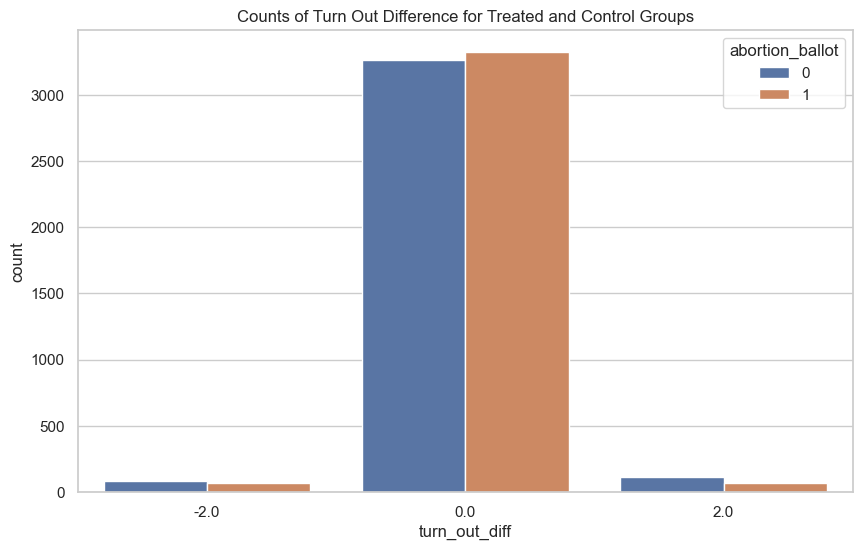

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='turn_out_diff', hue='abortion_ballot', data=matched_data)
plt.title('Counts of Turn Out Difference for Treated and Control Groups')
plt.show()

In [ ]:
get_two_sample_t_test(matched_treated, matched_control)

mean turn_out_diff in control is: -0.0023161551823972205
mean turn_out_diff in treatment is: 0.015055008685581933
t-statistic: -1.6618165081643976
p-value: 0.09659495775620722


In [ ]:
# Now we want to treat states that have abortion on ballot differently depending on the type of ballot question
protect_abortion_states = [6, 26, 50]
against_abortion_states = [21, 30]
prop_match_df['abortion_ballot'] = prop_match_df['state'].apply(lambda row: 2 if row in protect_abortion_states else (1 if row in against_abortion_states else 0))

In [ ]:
# Compare only states that have ballot questions supporting abortion rights to states without abortion ballot questions
prop_match_df_for = prop_match_df[prop_match_df['abortion_ballot'].isin([0,2])]
prop_match_df_for['abortion_ballot'] = prop_match_df_for['abortion_ballot'].replace(2, 1)

# Compare only states that have ballot questions prohibiting abortion rights to states without abortion ballot questions
prop_match_df_against = prop_match_df[prop_match_df['abortion_ballot'].isin([0,1])]

/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_66670/2884050334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prop_match_df_for['abortion_ballot'] = prop_match_df_for['abortion_ballot'].replace(2, 1)


In [ ]:
#For Abortion State vs No Abortion State
matched_control, matched_treated, matched_data = get_matching(prop_match_df_for, Z_var, X_var, caliper=0.005)
validation_results = validate_matching(Z_var, matched_control, matched_treated, matched_data)
validation_results

/Users/violethuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/violethuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_66670/2642755188.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

Number of instances in total matches  5854


/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_66670/2642755188.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  validation_results = validation_results.append({
/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_66670/2642755188.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  validation_results = validation_results.append({
/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_66670/2642755188.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  validation_results = validation_results.append({
/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_66670/2642755188.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

,Variable,Mean Difference,t-statistic,p-value
0,gender,0.02289,1.784322,0.074475
1,educ,0.009224,0.25537,0.798455
2,fam_income,0.006833,0.079305,0.936795
3,urbancity,0.012641,0.563067,0.573432
4,presvote16post,0.031773,1.319748,0.187023
5,pew_bornagain,-0.009224,-0.851648,0.394479
6,pew_religimp,-0.054663,-1.306988,0.191319
7,pew_churatd,-0.050222,-1.16217,0.245261
8,pew_prayer,-0.017424,-0.278238,0.780849
9,pol_ideo,0.012641,0.430202,0.667081


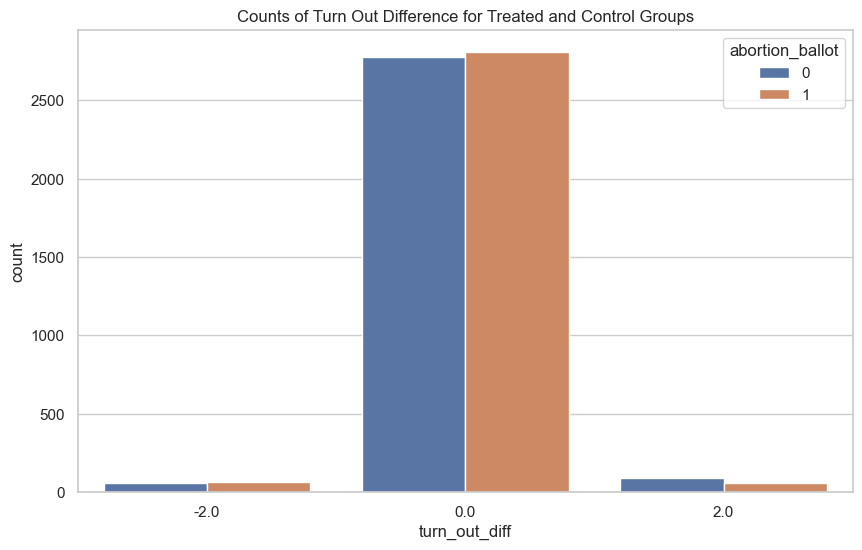

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='turn_out_diff', hue='abortion_ballot', data=matched_data)
plt.title('Counts of Turn Out Difference for Treated and Control Groups')
plt.show()

In [ ]:
get_two_sample_t_test(matched_treated, matched_control)

mean turn_out_diff in control is: -0.004099760847283909
mean turn_out_diff in treatment is: 0.020498804236419543
t-statistic: -2.208252294868455
p-value: 0.027265320654155357


In [ ]:
#Against Abortion State vs No Abortion State
matched_control, matched_treated, matched_data = get_matching(prop_match_df_against, Z_var, X_var, caliper=0.005)
validation_results = validate_matching(Z_var, matched_control, matched_treated, matched_data)
validation_results

/Users/violethuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/violethuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_66670/2642755188.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

Number of instances in total matches  1042


/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_66670/2642755188.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  validation_results = validation_results.append({
/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_66670/2642755188.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  validation_results = validation_results.append({
/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_66670/2642755188.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  validation_results = validation_results.append({
/var/folders/zg/n9l4w3gd6w98b4wdky4vmq1m0000gn/T/ipykernel_66670/2642755188.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

,Variable,Mean Difference,t-statistic,p-value
0,gender,-0.053743,-1.774524,0.076562
1,educ,-0.042226,-0.460391,0.645428
2,fam_income,0.024952,0.138066,0.890242
3,urbancity,0.107486,1.903351,0.057547
4,presvote16post,-0.038388,-0.59778,0.550247
5,pew_bornagain,-0.019194,-0.664834,0.506452
6,pew_religimp,0.051823,0.557668,0.577311
7,pew_churatd,0.046065,0.429746,0.667558
8,pew_prayer,0.038388,0.271722,0.785943
9,pol_ideo,-0.023033,-0.289766,0.772111


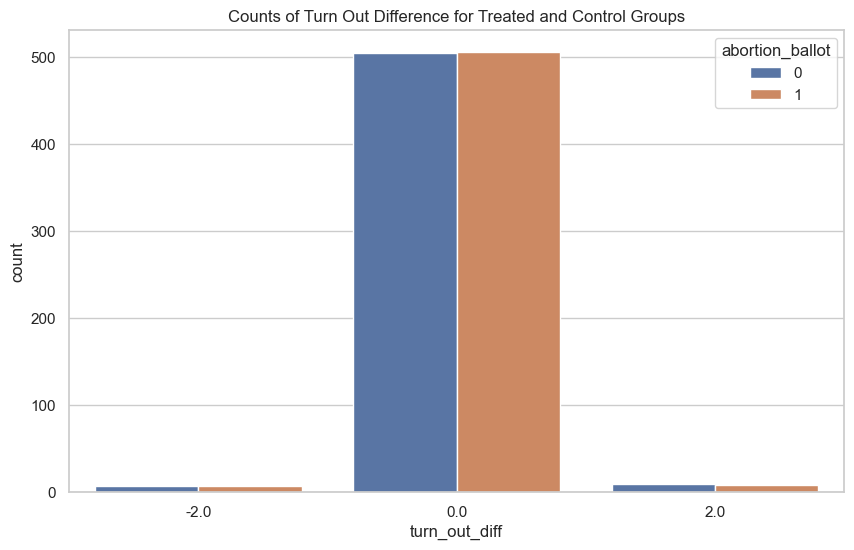

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='turn_out_diff', hue='abortion_ballot', data=matched_data)
plt.title('Counts of Turn Out Difference for Treated and Control Groups')
plt.show()

In [ ]:
get_two_sample_t_test(matched_treated, matched_control)

mean turn_out_diff in control is: 0.003838771593090211
mean turn_out_diff in treatment is: 0.007677543186180422
t-statistic: -0.17946063401938853
p-value: 0.8576109820915202
